In [2]:
#Run this to troubleshoot some problem with the cairo library (happens in macos)
#Also, need to add to settings.json the following:
#"terminal.integrated.env.osx": {
#     "DYLD_LIBRARY_PATH": "/opt/homebrew/opt/cairo/lib:${env:DYLD_LIBRARY_PATH}"
# },

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/cairo/lib:$DYLD_LIBRARY_PATH'


In [2]:
import sys
sys.path.append('/Users/evatakou/noise_est')
# from color_code_stim import *
from color_code_stim_copy import *
from noise_est_funcs_for_color_code import *
from utilities_for_color_code import *
from numerical_equations_for_color_code import *

import matplotlib.pyplot as plt 
import pymatching 
from pymatching import Matching 
from utilities_for_color_code import *
from construct_dem import *
from defects_matrix_construction import *


In [ ]:
stim.Tableau.to_stabilizers()

TypeError: to_circuit(): incompatible function arguments. The following argument types are supported:
    1. (self: stim._stim_polyfill.Tableau, method: str = 'elimination') -> stim._stim_polyfill.Circuit

Invoked with: 

In [14]:
T=stim.Tableau.random(3)
print(T)
T.to_stabilizers()

+-xz-xz-xz-
| ++ -+ ++
| YX _Z _X
| XZ ZY YZ
| YZ Z_ X_


[stim.PauliString("+XZZ"), stim.PauliString("+ZY_"), stim.PauliString("+XZ_")]

In [33]:
get_observables([stim.PauliString("+XZZ"), stim.PauliString("+ZY_")])

[(stim.PauliString("+Z_X"), stim.PauliString("+__Z"))]

In [25]:
def get_observables(
    stabilizers: list[stim.PauliString],
) -> list[tuple[stim.PauliString, stim.PauliString]]:
    completed_tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_redundant=True,
        allow_underconstrained=True,
    )

    observables = []
    for k in range(len(completed_tableau))[::-1]:
        z = completed_tableau.z_output(k)
        if z in stabilizers:
            break
        x = completed_tableau.x_output(k)
        observables.append((x, z))

    return observables

get_observables([stim.PauliString("ZZI"),
    stim.PauliString("IZZ"),
])

[(stim.PauliString("+XXX"), stim.PauliString("+__Z"))]

In [19]:
# T=stim.TableauSimulator()
T=stim.Tableau.from_stabilizers([
    stim.PauliString("ZZI"),
    stim.PauliString("IZZ"),
    stim.PauliString("ZZZ")])

T.to_stabilizers()

# get_observables(T.to_stabilizers())

[stim.PauliString("+ZZ_"), stim.PauliString("+_ZZ"), stim.PauliString("+ZZZ")]

In [ ]:
#W/ Parallel processing

from joblib import Parallel, delayed

def compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots):

    num_rounds = d
    obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
    circuit    = obj.circuit
 
    # num_ancilla   = len(obj.qubit_groups['anc'])
    Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
    Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

    dems_stim                     = {}

    for color in ["r", "g", "b"]: 
        # dem1,dem2        = obj.get_decomposed_dems(color)
        dem1,dem2= obj.decompose_detector_error_model([],color)
        dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel    

    # for color in ["r", "g", "b"]: 
    #     dem1,dem2        = obj.get_decomposed_dems(color)
    #     dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel


    #------- Estimation -------------------------------------

    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)


    min_bound = 1e-12
    max_bound = 0.6 
    method    =  "least_squares"  #minimize method does not work well

    vi_mean_Z      = avg_vi(defects_matrix_Z)
    vivj_mean_Z    = avg_vivj(defects_matrix_Z.data)
    p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
    detector_type  = "Z"
    vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
    sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

    if len(defects_matrix_X)>0: #non-empty

        vi_mean_X      = avg_vi(defects_matrix_X)
        vivj_mean_X    = avg_vivj(defects_matrix_X.data)
        p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds)
        detector_type  = "X"
        vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
        sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


    sols_for_defect_type           = sols_for_Z
    vi_mean                        = vi_mean_Z 
    vivj_mean                      = vivj_mean_Z 
    stims_DEM                      = Z_DEM 
    defects_type                   = "Z"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)

    
    
    error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM)

    if len(defects_matrix_X)>0:

        sols_for_defect_type           = sols_for_X
        vi_mean                        = vi_mean_X 
        vivj_mean                      = vivj_mean_X 
        stims_DEM                      = X_DEM 
        defects_type                   = "X"
        pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
        error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
    else:
        my_X_DEM={}

    r_only_DEM_mine,r_restricted_DEM_mine=create_lattices('r',my_Z_DEM,my_X_DEM,obj)
    b_only_DEM_mine,b_restricted_DEM_mine=create_lattices('b',my_Z_DEM,my_X_DEM,obj)
    g_only_DEM_mine,g_restricted_DEM_mine=create_lattices('g',my_Z_DEM,my_X_DEM,obj)

    dems_mine      = {}
    dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
    dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
    dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

    #Find the detector coordinates and pass them to my dems

    for color in ['r','b','g']:

        for j in range(2):

            temp = dems_stim[color][j]
            
            for instruction in temp:
                if instruction.type=="error":
                    continue 
                else:
                    
                    dems_mine[color][j].append(instruction)

    # num_shots = 10**7
    det, obs  = obj.sample(num_shots)
    preds_obs = obj.decode(det, dems_stim, verbose=False)

    fails_stim = np.logical_xor(obs, preds_obs)
    preds_obs  = obj.decode(det, dems_mine, verbose=False)
    fails_mine = np.logical_xor(obs, preds_obs)


    stims_LE = sum(fails_stim)/num_shots
    my_LE    = sum(fails_mine)/num_shots

    return stims_LE,my_LE

def get_logical_error_rate_vs_p_and_d(num_shots_for_est, num_shots, n_jobs=-1):

    Ls = [5, 7,9,11 ] 
    ps = [2e-4, 5e-4, 2.5e-3, 5e-3, 1e-2]

    error_per_d_stim = []
    error_per_d_mine = []

    for d in Ls:
        print(f"Running d = {d} ...")

        # Wrap one (d, p_circuit) pair into a function for parallelization
        def run_for_p(p_circuit):
            print(f"---Running p = {p_circuit} ...")
            stims_LE, my_LE = compare_logical_error_rate(d, p_circuit, num_shots_for_est, num_shots)
            print(f"---Done p = {p_circuit}")
            return stims_LE, my_LE

        # Run in parallel across different p values for the same d
        results = Parallel(n_jobs=n_jobs)(
            delayed(run_for_p)(p) for p in ps
        )

        # Collect results
        error_per_p_stim = [res[0] for res in results]
        error_per_p_mine = [res[1] for res in results]

        error_per_d_stim.append(error_per_p_stim)
        error_per_d_mine.append(error_per_p_mine)

        print(f"Done d = {d}")

    return Ls, ps, error_per_d_stim, error_per_d_mine


num_shots_for_est                       = 10**6
num_shots                               = 10**6
Ls,ps,error_per_d_stim,error_per_d_mine = get_logical_error_rate_vs_p_and_d(num_shots_for_est,num_shots)


([<matplotlib.axis.XTick at 0x153a5ff90>,
 [Text(0.0005, 0, '5$\\times 10^{-4}$'),
  Text(0.002, 0, '2$\\times 10^{-3}$'),
  Text(0.005, 0, '5$\\times 10^{-3}$'),
  Text(0.01, 0, '$10^{-2}$')])

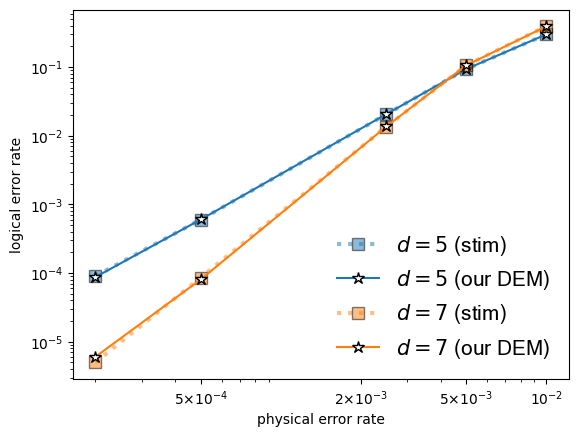

In [ ]:
#Plot our results
from matplotlib import pyplot as plt 
import matplotlib
fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    


colors = ['tab:blue','tab:orange','tab:green','tab:cyan','tab:purple']

cnt = 0
for L in Ls:
    
    plt.plot(ps,error_per_d_stim[cnt],marker='s',linestyle=':',color=colors[cnt]
                    ,linewidth=3,markeredgecolor='black',
                    markersize=9,alpha=0.5)
    plt.plot(ps,error_per_d_mine[cnt],marker='*',color=colors[cnt],
                    markersize=9,markeredgecolor='black',markerfacecolor='white')
    
    # plt.plot(ps,rel_err_all[cnt],marker='s')
    cnt+=1

    plt.legend(["$d=5$ (stim)","$d=5$ (our DEM)",
                "$d=7$ (stim)","$d=7$ (our DEM)",
                "$d=9$ (stim)","$d=9$ (our DEM)",
                "$d=11$ (stim)","$d=11$ (our DEM)"],
                frameon=False,
                 shadow=True,
                 fontsize=15)
    
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.yscale('log')
plt.xscale('log')
plt.xticks(ticks=[5e-4,
                  2e-3,
                  5e-3,
                  1e-2],
        labels=[ r"5$\times 10^{-4}$",
                r"2$\times 10^{-3}$",
                r"5$\times 10^{-3}$",                      
                "$10^{-2}$",])


# fig.savefig("threshold.pdf",bbox_inches='tight')


In [ ]:
with open("stims_LE_threshold.txt", "w") as file:
    file.write(str(error_per_d_stim))
with open("all_errors_my_DEM.txt", "w") as file:
    file.write(str(error_per_d_mine))    
with open("ps_threshold.txt", "w") as file:
    file.write(str(ps))   
with open("Ls_threshold.txt", "w") as file:
    file.write(str(Ls))   
    